# Object Detection with AzureML AutoML

### References:

[Tutorial: Train an object detection model with AutoML and Python](https://github.com/Azure/azureml-examples/blob/main/sdk/python/jobs/automl-standalone-jobs/automl-image-object-detection-task-fridge-items/automl-image-object-detection-task-fridge-items.ipynb)

[Convert PASCAL VOC to COCO](https://www.kaggle.com/code/ramsikalia/pascal-voc-xml-to-coco-json-for-car-damage-dataset)

In this playground, I want to follow a tutorial from AzureML AutoML that provides a step-by-step guide on training an object detection model using AzureML Python SDK. While I intend to reproduce each step, there might be slight differences from the original tutorial. I'll be working with a different dataset, which I'll explain later. Please note that I don't execute all the cells in one go; I've spent several days working on this. Also, some outputs are intentionally omitted due to potentially sensitive information.

Let's begin by installing the necessary package before importing it.

In [ ]:
!pip install azure-ai-ml azure-identity

Then we can import the necessary libraries.

In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential, EnvironmentCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

from azure.ai.ml.automl import SearchSpace, ObjectDetectionPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

Connecting to a workspace requires a subscription, a resource group and the workspace name. Here I use details of my workspace.

In [2]:
credential = DefaultAzureCredential(logging_enable=True)
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<subscription id>"
    resource_group = "<resource group>"
    workspace = "<workspace name>"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

Found the config file in: D:\personal files\self-learn\data, ai, ml\.azureml\config.json


Now let’s work on the data. The data used in the tutorial is in Pascal VOC format, so I found a dataset with a similar format and found [Road Sign Detection](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection) dataset from Kaggle. This dataset consists of 877 images of 4 labels, traffic light, stop, speedlimit, and crosswalk. 

To download Kaggle datasets using Kaggle API, we need to install the Kaggle package and set up the Kaggle API token.

In [ ]:
!pip install kaggle

I created a new API token through my Kaggle account and got the credentials. Then we can proceed to download and unzip the dataset.

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set Kaggle API credentials using environment variables
os.environ["KAGGLE_USERNAME"] = "<kaggle username>"
os.environ["KAGGLE_KEY"] = "<kaggle api key>"

# Change to a different location if you prefer
dataset_parent_dir = "../datasets/"

# create data folder if it doesn't exist
os.makedirs(dataset_parent_dir, exist_ok=True)

# Kaggle dataset name
dataset_name = 'andrewmvd/road-sign-detection'

# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name.split('/')[1])

# Get the data zip file path
data_file = os.path.join(dataset_parent_dir, f"{dataset_name.split('/')[1]}.zip")

# Download the dataset using Kaggle API
api = KaggleApi()
api.authenticate()  # This will use the credentials set via environment variables
api.dataset_download_files(dataset_name, path=dataset_parent_dir)

In [ ]:
import zipfile

with zipfile.ZipFile(data_file, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

Get a sample image from that dataset:

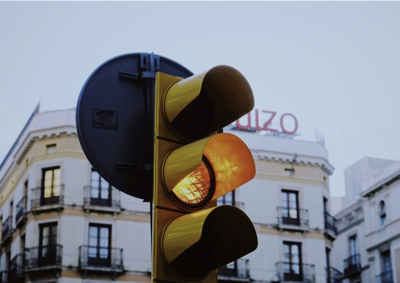

In [8]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "images", "road1.png")
Image(filename=sample_image)

Upload the data to Azure Blob Storage to use the data for training later. What I did not show here is the error I encountered related to DefaultAzureCredential authentication issues. I solved it by following the AzureCliCredential troubleshooting since (as far as I know) DefaultAzureCredential uses some of the credential methods to access a token and stops when one of the methods returns a token.

In [ ]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="Road sign object detection",
    name="road-sign-images-object-detection",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

To use this data, we need to convert it to the required JSONL format. Because the code in the tutorial gets some error and I can’t solve it (😅), instead I convert the dataset from VOC format to JSON first then convert it again to JSONL.

I encountered so many trials and errors in reproducing the exact data format expected for training. The crucial part is the image_url where I get the most error. I solve it by inserting the path to the folder in Blob Storage before the local file name.

In [1]:
import xml.etree.ElementTree as ET
import os
import json

convert_to_json = dict()
convert_to_json['images'] = []
convert_to_json['type'] = 'instances'
convert_to_json['annotations'] = []
convert_to_json['categories'] = []

category_set = dict()
image_set = set()

category_item_id = 0
image_id = 0
annotation_id = 0

In [24]:
def addCatItem(name):
    global category_item_id
    if name not in category_set:
        category_item_id += 1
        category_item = {
            'supercategory': 'none',
            'id': category_item_id,
            'name': name
        }
        convert_to_json['categories'].append(category_item)
        category_set[name] = category_item_id
    
    return category_set[name]

In [25]:
def addImgItem(file_name, size):
    global image_id
    
    if file_name is None:
        raise Exception('Could not find filename tag in xml file.')
    if size['width'] is None:
        raise Exception('Could not find width tag in xml file.')
    if size['height'] is None:
        raise Exception('Could not find height tag in xml file.')
        
    if file_name not in image_set:
        image_id += 1
        image_item = {
            'id': image_id,
            'file_name': file_name,
            'width': size['width'],
            'height': size['height']
        }
        convert_to_json['images'].append(image_item)
        image_set.add(file_name)
    
    return image_id

In [26]:
def addAnnoItem(object_name, image_id, category_id, bbox, filename, size):
    global annotation_id
    
    image_url = f"<path to folder>{filename}"
        
    image_details = {
        'format': 'png',
        'width': size['width'],
        'height': size['height']
    },
        
    label_info = {
        'label': object_name,
        'topX': bbox[0] / size['width'],
        'topY': bbox[1] / size['height'],
        'bottomX': bbox[2] / size['width'],
        'bottomY': bbox[3] / size['height'],
        'isCrowd': 0
    }
    
    # Check if an entry for the current image already exists
    existing_entry = next((anno for anno in convert_to_json['annotations'] if anno['image_url'] == image_url), None)

    if existing_entry:
        # Append label information to the existing entry
        existing_entry['label'].append(label_info)
    else:
        # Create a new entry for the image
        annotation_item = {
            'image_url': image_url,
            'image_details': image_details,
            'label': [label_info]
        }
        convert_to_json['annotations'].append(annotation_item)
        

In [27]:
def parseXmlFiles(xml_path): 
    for f in os.listdir(xml_path):
        if not f.endswith('.xml'):
            continue
        
        bndbox = dict()
        size = dict()
        current_image_id = None
        current_category_id = None
        file_name = None
        size['width'] = None
        size['height'] = None
        size['depth'] = None

        xml_file = os.path.join(xml_path, f)
        print(xml_file)

        tree = ET.parse(xml_file)
        root = tree.getroot()
        if root.tag != 'annotation':
            raise Exception('pascal voc xml root element should be annotation, rather than {}'.format(root.tag))

        #elem is <folder>, <filename>, <size>, <object>
        for elem in root:
            current_parent = elem.tag
            current_sub = None
            object_name = None
            
            if elem.tag == 'folder':
                continue
            
            if elem.tag == 'filename':
                file_name = elem.text
                if file_name in category_set:
                    raise Exception('file_name duplicated')
                
            #add img item only after parse <size> tag
            elif current_image_id is None and file_name is not None and size['width'] is not None:
                if file_name not in image_set:
                    current_image_id = addImgItem(file_name, size)
                    print('add image with {} and {}'.format(file_name, size))
                else:
                    raise Exception('duplicated image: {}'.format(file_name)) 
            #subelem is <width>, <height>, <depth>, <name>, <bndbox>
            for subelem in elem:
                bndbox ['xmin'] = None
                bndbox ['xmax'] = None
                bndbox ['ymin'] = None
                bndbox ['ymax'] = None
                
                current_sub = subelem.tag
                if current_parent == 'object' and subelem.tag == 'name':
                    object_name = subelem.text
                    if object_name not in category_set:
                        current_category_id = addCatItem(object_name)
                    else:
                        current_category_id = category_set[object_name]

                elif current_parent == 'size':
                    if size[subelem.tag] is not None:
                        raise Exception('xml structure broken at size tag.')
                    size[subelem.tag] = int(subelem.text)

                #option is <xmin>, <ymin>, <xmax>, <ymax>, when subelem is <bndbox>
                for option in subelem:
                    if current_sub == 'bndbox':
                        if bndbox[option.tag] is not None:
                            raise Exception('xml structure corrupted at bndbox tag.')
                        bndbox[option.tag] = int(option.text)

                #only after parse the <object> tag
                if bndbox['xmin'] is not None:
                    if object_name is None:
                        raise Exception('xml structure broken at bndbox tag')
                    if current_image_id is None:
                        raise Exception('xml structure broken at bndbox tag')
                    if current_category_id is None:
                        raise Exception('xml structure broken at bndbox tag')
                    bbox = [
                        bndbox['xmin'], bndbox['ymin'], bndbox['xmax'], bndbox['ymax']]
                    
                    print('add annotation with {},{},{},{}'.format(object_name, current_image_id, current_category_id, bbox))
    
                    addAnnoItem(object_name, current_image_id, current_category_id, bbox, file_name, size)

In [28]:
def build_json_ann(xml_path, output_path):
    parseXmlFiles(xml_path)
    json.dump(convert_to_json, open(output_path, 'w'))

In [29]:
voc_ann_dir = os.path.join("../datasets", "road-sign-detection", "annotations")
save_dir = os.path.join("../datasets", "road-sign-detection", "annotations_voc.json")

build_json_ann(voc_ann_dir, save_dir)

../datasets\road-sign-detection\annotations\road0.xml
add image with road0.png and {'width': 267, 'height': 400, 'depth': 3}
add annotation with trafficlight,1,1,[98, 62, 208, 232]
../datasets\road-sign-detection\annotations\road1.xml
add image with road1.png and {'width': 400, 'height': 283, 'depth': 3}
add annotation with trafficlight,2,1,[154, 63, 258, 281]
../datasets\road-sign-detection\annotations\road10.xml
add image with road10.png and {'width': 400, 'height': 267, 'depth': 3}
add annotation with trafficlight,3,1,[106, 3, 244, 263]
../datasets\road-sign-detection\annotations\road100.xml
add image with road100.png and {'width': 400, 'height': 385, 'depth': 3}
add annotation with speedlimit,4,2,[35, 5, 363, 326]
../datasets\road-sign-detection\annotations\road101.xml
add image with road101.png and {'width': 400, 'height': 200, 'depth': 3}
add annotation with speedlimit,5,2,[195, 7, 392, 194]
../datasets\road-sign-detection\annotations\road102.xml
add image with road102.png and {'

In [30]:
import json

# Load the original JSON file
with open('../datasets/road-sign-detection/annotations_voc.json', 'r') as f:
    json_data = json.load(f)

# Extract the list of annotations from the "annotations" key
annotations_list = json_data.get("annotations", [])

# Write to the JSONL file
with open('../datasets/road-sign-detection/annotations_voc.jsonl', 'w') as jsonl_output:
    for entry in annotations_list:
        json.dump(entry, jsonl_output)
        jsonl_output.write('\n')


Try to visualize the ground truth bounding boxes for an image before starting to train.

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image as pil_image
import numpy as np
import json
import os

def plot_ground_truth_boxes(image_file, ground_truth_boxes):
    
    # Display the image
    plt.figure()
    img_np = mpimg.imread(image_file)
    img = pil_image.fromarray(img_np.astype("uint8"), "RGB")
    img_w, img_h = img.size

    fig, ax = plt.subplots(figsize=(12, 16))
    ax.imshow(img_np)
    ax.axis("off")

    label_to_color_mapping = {}
    
    for gt in ground_truth_boxes:
        label = gt["label"]

        xmin, ymin, xmax, ymax =  gt["topX"], gt["topY"], gt["bottomX"], gt["bottomY"]
        topleft_x, topleft_y = img_w * xmin, img_h * ymin
        width, height = img_w * (xmax - xmin), img_h * (ymax - ymin)

        if label in label_to_color_mapping:
            color = label_to_color_mapping[label]
        else:
            # Generate a random color. If you want to use a specific color, you can use something like "red".
            color = np.random.rand(3)
            label_to_color_mapping[label] = color

        # Display bounding box
        rect = patches.Rectangle((topleft_x, topleft_y), width, height,
                                 linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)

        # Display label
        ax.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)

    plt.show()

def plot_ground_truth_boxes_jsonl(image_file, jsonl_file):
    image_base_name = os.path.basename(image_file)
    ground_truth_data_found = False
    
    with open(jsonl_file) as fp:
        for line in fp.readlines():
            line_json = json.loads(line)
            filename = line_json["image_url"]
            if image_base_name in filename:
                ground_truth_data_found = True
                plot_ground_truth_boxes(image_file, line_json["label"])
            
    if not ground_truth_data_found:
        print("Unable to find ground truth information for image: {}".format(image_file))

<Figure size 640x480 with 0 Axes>

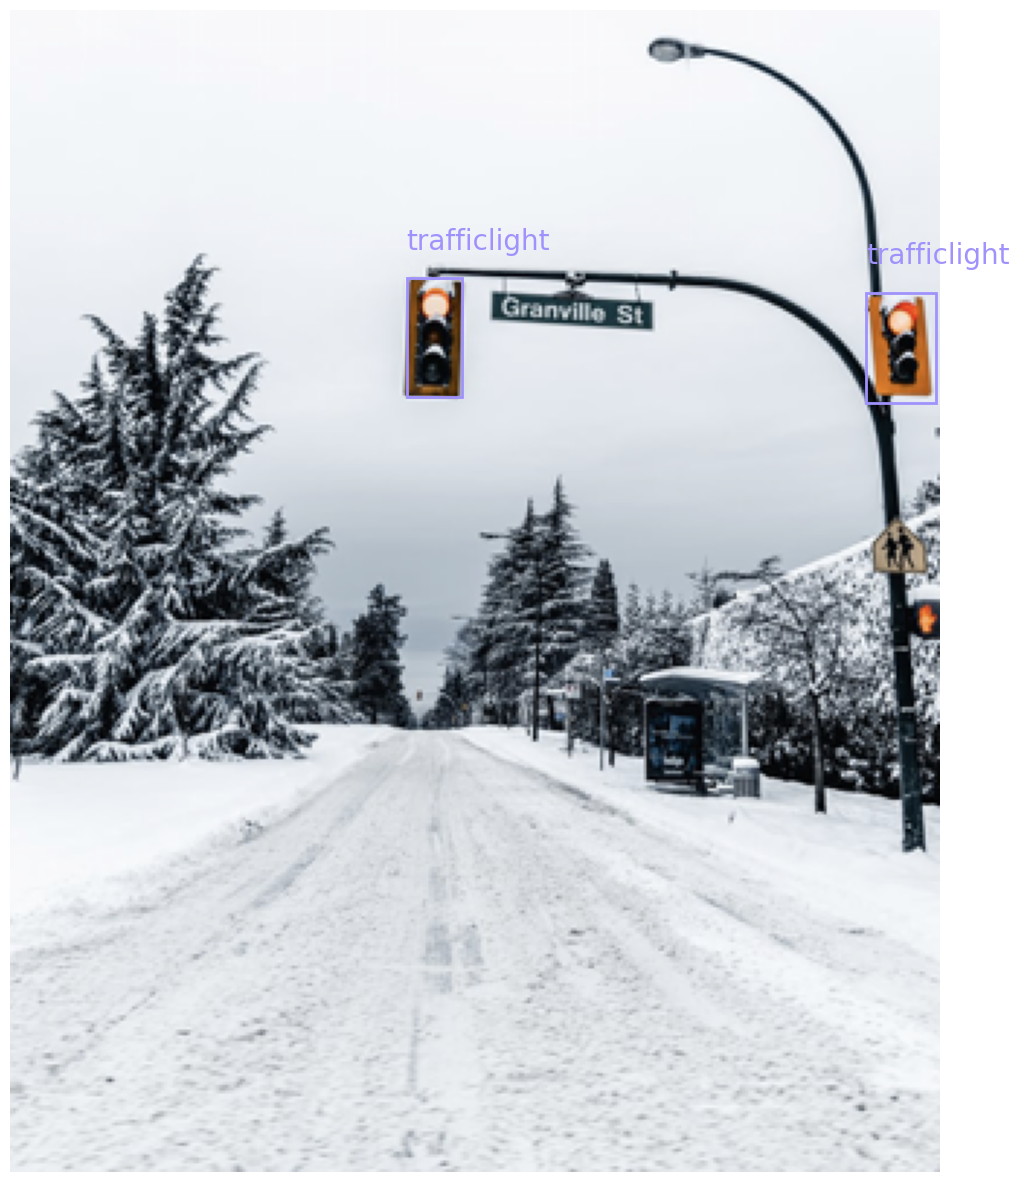

In [77]:
image_file = "../datasets/road-sign-detection/images/road12.png"
jsonl_file = "../datasets/road-sign-detection/annotations_voc.jsonl"

plot_ground_truth_boxes_jsonl(image_file, jsonl_file)

Split the data into train and validation:

In [39]:
import os

dataset_parent_dir = "../datasets/road-sign-detection"

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_parent_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_parent_dir, "validation-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

jsonl_annotations = '../datasets/road-sign-detection/annotations_voc.jsonl'
with open(jsonl_annotations, "r") as annot_f:
    json_lines = annot_f.readlines()

index = 0
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for json_line in json_lines:
            if index % train_validation_ratio == 0:
                # validation annotation
                validation_f.write(json_line)
            else:
                # train annotation
                train_f.write(json_line)
            index += 1

The next step is to create MLTable from the JSONL data before.

In [40]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)

def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)

# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Save train and validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [41]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes

# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)


Because this notebook just aims to walk through all of the processes from preparing the dataset to inferencing using the deployed model, so I just straightforwardly use AutoMode functionality to train. This will automatically choose the best model and hyperparameter.

In [46]:
# general job parameters
exp_name = "object-detection-experiment"

In [47]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="mean_average_precision",
)

image_object_detection_job.set_limits(
    max_trials=10,
    max_concurrent_trials=1,
)

From the tutorial, we can see that we need to provide a compute target for AutoML model training. I don't use the VM used in the tutorial because (as I remember) my subscription doesn't provide a quota for that VM. I use serverless compute instead.

In [48]:
from azure.ai.ml.entities import ResourceConfiguration

# Serverless compute resources used to run the job
image_object_detection_job.resources = ResourceConfiguration(instance_type="Standard_NC24rs_v3", instance_count=4)

Submit the configured job for training.

In [ ]:
# Submit the command job
returned_job = ml_client.create_or_update(image_object_detection_job)

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

After the training is finished, the models and artifacts produced by AutoML can be accessed with MLFlow Client. We can obtain the tracking URI for MLFlow.

In [ ]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

In [ ]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")

In [9]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

Get the AutoML parent job.

In [ ]:
job_name = "<job name>"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

In [ ]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

Get the AutoML best child run.

In [ ]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Below are the metrics of the best model.

In [13]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

0
precision               0.851720
log_loss_train          0.092879
recall                  0.950400
log_loss                0.127028
mean_average_precision  0.932730

Download the best model.

In [15]:
# Create local folder
local_dir = "../models/road-sign-detection"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [16]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

2024/03/23 11:31:07 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Artifacts downloaded in: D:\personal files\self-learn\data, ai, ml\models\road-sign-detection\outputs
Artifacts: ['conda_env_v_1_0_0.yml', 'generated_code', 'mlflow-model', 'model.pt', 'run_id.txt', 'scoring_file_v_1_0_0.py']


In [17]:
import os

mlflow_model_dir = os.path.join(local_dir, "outputs", "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

['artifacts',
 'conda.yaml',
 'MLmodel',
 'python_env.yaml',
 'python_model.pkl',
 'requirements.txt']

We can deploy the best model. First, we need to create an online endpoint.

In [29]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [ ]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime

online_endpoint_name = "road-sign-od-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is a sample online endpoint for deploying road sign object detection model",
    auth_mode="key",
)
print(online_endpoint_name)

In [ ]:
ml_client.begin_create_or_update(endpoint).result()

Next, register the model and update it.

In [36]:
model_name = "road-sign-od-mlflow-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="my road sign object detection model",
    type=AssetTypes.MLFLOW_MODEL,
)

In [37]:
registered_model = ml_client.models.create_or_update(model)

In [ ]:
registered_model.id

Finally, deploy it!

In [39]:
from azure.ai.ml.entities import OnlineRequestSettings

# Setting the request timeout to 90 seconds. Please note that if you use a GPU compute, inference would be faster
# and this setting may not be required.
req_timeout = OnlineRequestSettings(request_timeout_ms=90000)

In [46]:
deployment = ManagedOnlineDeployment(
    name="road-sign-od-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_D2A_V4",
    instance_count=1,
    request_settings=req_timeout,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [ ]:
ml_client.online_deployments.begin_create_or_update(deployment).result()

Let's test the deployment. Get the endpoint details first.

In [ ]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

This is the sample image to test the deployment. I download it from [here](https://media.npr.org/assets/img/2021/09/22/img_4973-1fff64cb2be877fb9678bd9a52bee4ea1e5f03ca.jpg).

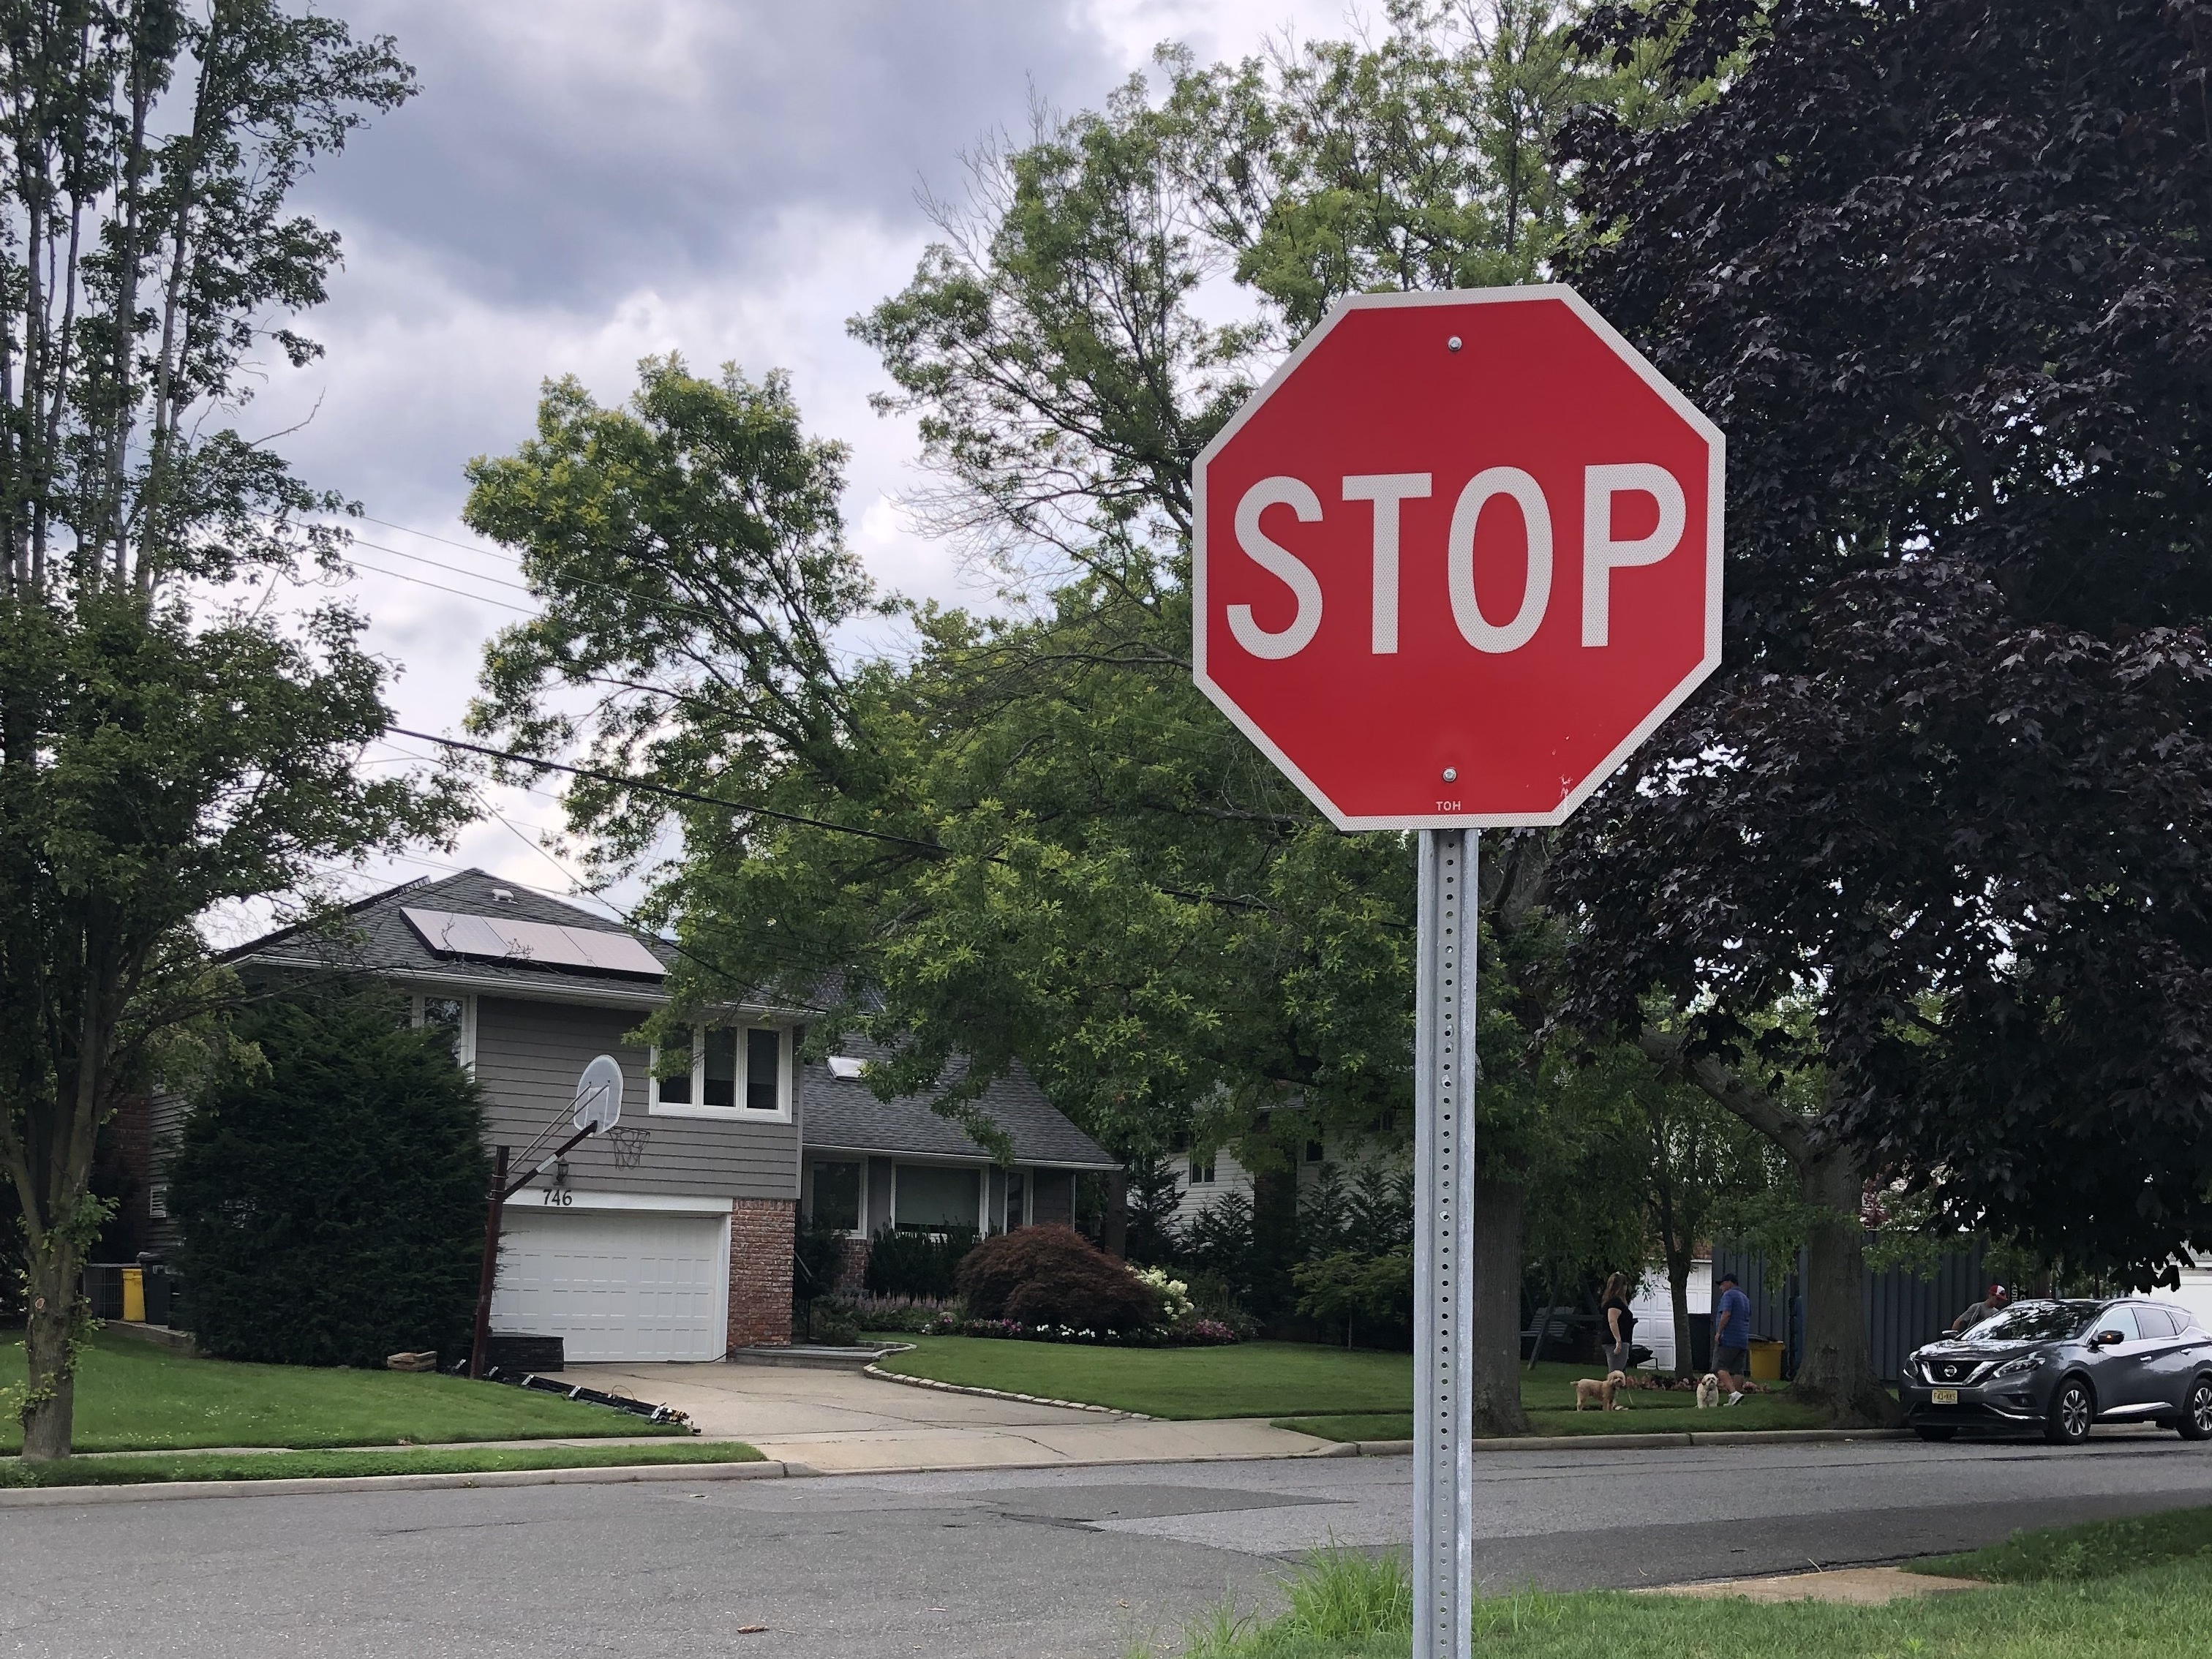

In [61]:
from IPython.display import Image
import base64

sample_test_image = os.path.join("../datasets/road-sign-detection/inference/", "test_image_2.jpg")
Image(filename=sample_test_image)

In [62]:
def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()
    
request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_test_image)).decode("utf-8")],
    }
}

In [63]:
import json

request_file_name = "request-road-sign-od.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [64]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

Then, visualize the bounding boxes from the response.

stop: [1647.142, 393.7, 694.525, 748.676], 0.88


<Figure size 1800x1200 with 0 Axes>

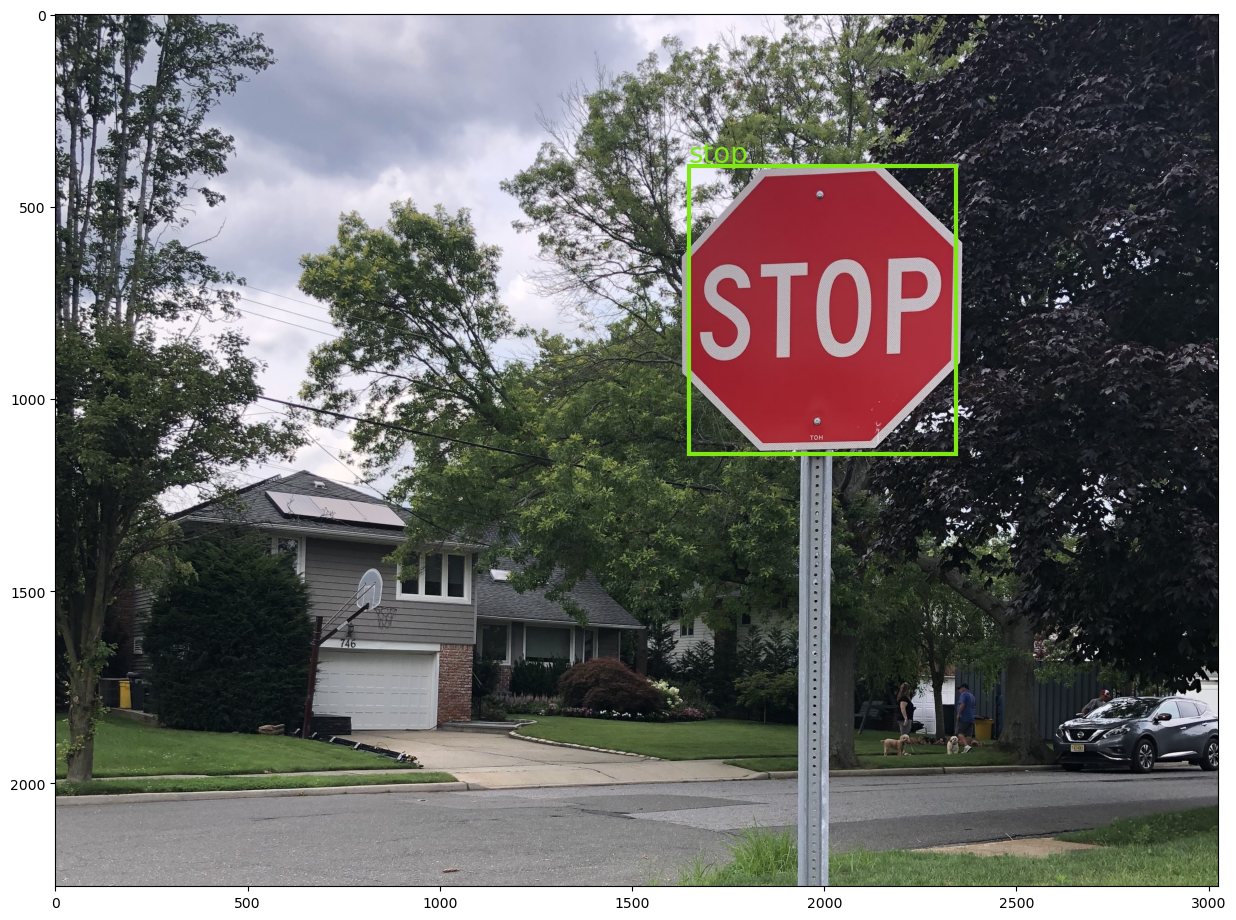

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_test_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection
detections = json.loads(resp)
for detect in detections[0]["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            f"{detect['label']}: [{round(topleft_x, 3)}, {round(topleft_y, 3)}, "
            f"{round(width, 3)}, {round(height, 3)}], {round(conf_score, 3)}"
        )

        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()

Looks good so far! We can delete the deployment and endpoint if we don't use it.

In [78]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)

...............................................................

### Next Step:

For the next notebook, I either want to try another AutoML task tutorial, try hyperparameter tuning, or maybe reproduce the model without Azure AutoML given the best model and hyperparameter from this experiment. Let's see where this will go...👀